In [20]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import time
from urllib.parse import urljoin
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

# =============================================================================
# KONFIGURASI
# =============================================================================
url_form = "https://bioinformatics.psb.ugent.be/webtools/plantcare/cgi-bin/qfm_querycare.htpl"
output_file = "PlantCARE_Vertical_Report.csv"

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Setup Koneksi
session = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))

all_data = []

print("--- MULAI SCRAPING (MODE LAPORAN VERTIKAL) ---")
print("==============================================")

# 1. Buka Halaman Awal
try:
    r = session.get(url_form, headers=headers)
    soup = BeautifulSoup(r.text, 'html.parser')
    form = soup.find('form')
    action = form.get('action')
    url_target = urljoin(url_form, action)
    
    payload = {
        'query': '', 
        'submit': 'Submit Query', 
        '.cgifields': 'query'
    }
except Exception as e:
    print(f"Error awal: {e}")
    exit()

# 2. Loop Halaman
current_url = url_target
halaman = 1
last_valid_id = "Unknown"
total_counter = 0

# Variabel deteksi looping
previous_page_data = [] 

while True:
    print(f"\n>> MEMPROSES HALAMAN {halaman}...")
    
    try:
        response = session.post(current_url, data=payload, headers=headers, timeout=30)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        rows = soup.find_all('tr')
        current_page_data = []
        
        for row in rows:
            cols = row.find_all('td')
            if len(cols) >= 2:
                col_id = cols[0].get_text(strip=True)
                col_seq = cols[-1].get_text(strip=True).upper()
                
                # Update ID jika ada
                if col_id and "ID of" not in col_id:
                    last_valid_id = col_id
                
                # SAYA PERLEBAR FILTERNYA
                # Mengizinkan kode IUPAC (R,Y,M,K,S,W,H,B,V,D) jaga-jaga kalau ada variasi
                valid_chars = "ACGTURYSWKMBDHVN()-0123456789"
                
                if len(col_seq) >= 3 and all(c in valid_chars for c in col_seq):
                    
                    total_counter += 1
                    
                    # --- CETAK VERTIKAL (REPORT) ---
                    print(f"   [{total_counter}] ID: {last_valid_id:<20} | Seq: {col_seq}")
                    
                    entry = {
                        'ID': last_valid_id, 
                        'Sequence': col_seq,
                        'Raw_Check': row.get_text(strip=True) 
                    }
                    current_page_data.append(entry)

        # --- CEK LOOPING ---
        if len(current_page_data) > 0 and current_page_data == previous_page_data:
            print("\n[STOP] Halaman ini SAMA PERSIS dengan sebelumnya. Selesai.")
            break
        
        if current_page_data:
            for item in current_page_data:
                final_item = {k: v for k, v in item.items() if k != 'Raw_Check'}
                all_data.append(final_item)
            previous_page_data = current_page_data
        else:
             print("   [INFO] Tidak ada sequence di halaman ini (mungkin header/footer).")

        # --- NEXT BUTTON ---
        next_btn = soup.find('input', {'value': re.compile(r'>>')})
        
        if next_btn:
            form_next = next_btn.find_parent('form')
            payload = {}
            for inp in form_next.find_all('input'):
                if inp.get('name'):
                    payload[inp.get('name')] = inp.get('value')
            
            payload[next_btn.get('name')] = next_btn.get('value')
            
            if form_next.get('action'):
                current_url = urljoin(url_form, form_next.get('action'))
            
            halaman += 1
        else:
            print("\n[SELESAI] Tombol Next habis.")
            break

    except Exception as e:
        print(f"\n[ERROR] {e}")
        break

# 3. Simpan
if all_data:
    print("\n==============================================")
    print("              REKAPITULASI DATA               ")
    print("==============================================")
    df = pd.DataFrame(all_data)
    print(f"Total Baris Terkumpul : {len(df)}")
    
    df.to_csv(output_file, index=False)
    print(f"File tersimpan di     : {output_file}")
else:
    print("Zonk.")

--- MULAI SCRAPING (MODE LAPORAN VERTIKAL) ---

>> MEMPROSES HALAMAN 1...
   [1] ID: H-box module         | Seq: AGCACCATACTTGGTA
   [2] ID: AAGAA-motif          | Seq: GAAAGAA
   [3] ID: AAGAA-motif          | Seq: GGTAAAGAAA
   [4] ID: CTAG-motif           | Seq: ACTAGCAGAA
   [5] ID: GT1-motif            | Seq: GGTTAAT
   [6] ID: GT1-motif            | Seq: ACAGAAGTAGGTTAATCAATTTCAGGTTAATCAAAGTGGAGATCGGAAAG

>> MEMPROSES HALAMAN 2...
   [7] ID: PE1                  | Seq: GGAAATAGCAAATGTTAAAAATA
   [8] ID: RE1                  | Seq: GGGCGCGGAACAAGGATCGGCGCGCCACGCC
   [9] ID: TATA-box             | Seq: TATATTTATATTT
   [10] ID: ABRE                 | Seq: TACGGTC
   [11] ID: ABRE                 | Seq: CACGTG
   [12] ID: ABRE                 | Seq: ACGTG
   [13] ID: ABRE                 | Seq: AACCCGG
   [14] ID: AC-I                 | Seq: GCTTACCTACCA
   [15] ID: ACA-motif            | Seq: AATCACAACCATA
   [16] ID: ACTCATCCT sequence   | Seq: ACTCATCCT

>> MEMPROSES HALAMAN 3...

In [21]:
import pandas as pd
from bs4 import BeautifulSoup
import re
import os

def parse_place_seq_html(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        content = f.read()

    soup = BeautifulSoup(content, 'html.parser')
    # The content is usually wrapped in <pre> tags in these html files
    pre_content = soup.find('pre')
    if pre_content:
        text_data = pre_content.get_text()
    else:
        text_data = content

    # Entries are separated by "//"
    entries = text_data.split('//')
    parsed_entries = []

    for entry in entries:
        entry = entry.strip()
        if not entry:
            continue

        # Initialize record structure
        data = {
            'ID': '',
            'AC': '',
            'DT': '',
            'DE': [],
            'KW': [],
            'OS': [],
            'RA': [],
            'RT': [],
            'RL': [],
            'RD': [],
            'SQ': []
        }

        lines = entry.split('\n')
        current_mode = 'meta' # 'meta' or 'sequence'

        for line in lines:
            line = line.rstrip() # remove trailing whitespace
            if not line:
                continue
            
            # Detect Sequence start
            if line.strip() == 'SQ' or line.startswith('SQ '):
                current_mode = 'sequence'
                continue
            
            if current_mode == 'sequence':
                # Filter sequence content (letters only)
                clean_seq = re.sub(r'[^A-Za-z]', '', line).upper()
                if clean_seq:
                    data['SQ'].append(clean_seq)
            else:
                # Parse metadata lines: "CODE   Value"
                if len(line) > 5 and line[2:5] == '   ':
                    code = line[:2]
                    val = line[5:].strip()
                    
                    if code in data:
                        if isinstance(data[code], list):
                            data[code].append(val)
                        else:
                            # For single value fields, just overwrite or append? 
                            # Usually ID, AC, DT are single lines.
                            data[code] = val
        
        # Build final dictionary
        flat_entry = {}
        flat_entry['ID'] = data['ID']
        flat_entry['Accession'] = data['AC']
        flat_entry['Date'] = data['DT']
        flat_entry['Description'] = ' '.join(data['DE'])
        flat_entry['Keywords'] = ' '.join(data['KW'])
        flat_entry['Organism'] = ' '.join(data['OS'])
        flat_entry['References'] = ' | '.join(data['RA']) # Multiple authors?
        flat_entry['Reference_Title'] = ' '.join(data['RT'])
        flat_entry['Sequence'] = ''.join(data['SQ'])
        
        parsed_entries.append(flat_entry)

    return pd.DataFrame(parsed_entries)

# Execution
input_file = 'place.seq.html'
output_file = 'place_seq.csv'

if os.path.exists(input_file):
    print(f"Parsing {input_file}...")
    df_result = parse_place_seq_html(input_file)
    
    # Save
    df_result.to_csv(output_file, index=False)
    print(f"Done! Saved {len(df_result)} entries to '{output_file}'.")
    
    # Preview
    print(df_result.head())
else:
    print(f"Error: '{input_file}' not found in current directory.")

Parsing place.seq.html...
Done! Saved 469 entries to 'place_seq.csv'.
                ID Accession                              Date  \
0      -10PEHVPSBD   S000392  20-Feb-2002 (last modified) uchi   
1        -141NTG13   S000335  16-Feb-2001 (last modified) seki   
2  -284MOTIFZMSBE1   S000285  10-Feb-2000 (last modified) seki   
3         -300CORE   S000001  10-May-2006 (last modified) kehi   
4      -300ELEMENT   S000122  11-May-2006 (last modified) kehi   

                                         Description  \
0  "-10 promoter element" found in the barley (H....   
1  "-141 sequence"; Binding site of tobacco (N.t....   
2  Located between -284 and -255 region of maize ...   
3  "TGTAAAG core motif" in "-300 elements" of alp...   
4  Present upstream of the promoter from the B-ho...   

                                            Keywords  \
0  psbD; chloroplast gene expression; circadian r...   
1  TGA1a; G13; ASF1; ASF-1; bZip; xenobiotic stre...   
2  Starch-branching enzyme (

In [10]:
import os
import pandas as pd

# Save only ID and Sequence columns to a separate CSV
output_simple_file = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/place_seq_id_seq.csv'

df_result = pd.read_csv('/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/place_seq.csv')

if 'df_result' in locals():
    # Use dataframe from memory if available
    df_subset = df_result[['ID', 'Sequence']]
    df_subset.to_csv(output_simple_file, index=False)
    print(f"Saved simplified data (ID, Sequence) to '{output_simple_file}'.")
    print(df_subset.head())
elif os.path.exists('place_seq.csv'):
    # Load from the CSV generated in the previous step
    df_loaded = pd.read_csv('place_seq.csv')
    df_subset = df_loaded[['ID', 'Sequence']]
    df_subset.to_csv(output_simple_file, index=False)
    print(f"Saved simplified data (ID, Sequence) to '{output_simple_file}'.")
    print(df_subset.head())
else:
    print("No data found to process. Please run the previous cell first.")

Saved simplified data (ID, Sequence) to '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/place_seq_id_seq.csv'.
                ID                        Sequence
0      -10PEHVPSBD                          TATTCT
1        -141NTG13           GCTTTTGATGACTTCAAACAC
2  -284MOTIFZMSBE1  CGTGCAAGCCCAAAGGCCAATCGGCCCAGA
3         -300CORE                         TGTAAAG
4      -300ELEMENT                        TGHAAARK


In [11]:
# Merge datasets with priority to PlantCARE
plantcare_path = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/PlantCARE_Vertical_Report.csv'
placeseq_path = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/place_seq_id_seq.csv'
output_merged_path = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_place_seq.csv'

if os.path.exists(plantcare_path) and os.path.exists(placeseq_path):
    print("Loading datasets...")
    df_plantcare = pd.read_csv(plantcare_path)
    df_placeseq = pd.read_csv(placeseq_path)
    
    # Standardize column names if needed (assuming ID, Sequence)
    # Just to be safe, strip whitespace
    df_plantcare.columns = [c.strip() for c in df_plantcare.columns]
    df_placeseq.columns = [c.strip() for c in df_placeseq.columns]

    print(f"PlantCARE entries: {len(df_plantcare)}")
    print(f"PlaceSeq entries: {len(df_placeseq)}")

    # Normalize sequences for comparison (uppercase, strip)
    df_plantcare['Sequence'] = df_plantcare['Sequence'].astype(str).str.upper().str.strip()
    df_placeseq['Sequence'] = df_placeseq['Sequence'].astype(str).str.upper().str.strip()

    # Add source column for tracking (optional)
    df_plantcare['Source'] = 'PlantCARE'
    df_placeseq['Source'] = 'PlaceSeq'

    # Concatenate with PlantCARE FIRST so it is earlier in the index
    df_merged = pd.concat([df_plantcare, df_placeseq], ignore_index=True)

    # Drop duplicates based on 'Sequence', keeping 'first' (which is PlantCARE)
    df_unique = df_merged.drop_duplicates(subset=['Sequence'], keep='first')
    
    print(f"Total Combined: {len(df_merged)}")
    print(f"Unique Sequences: {len(df_unique)}")
    print(f"Duplicates Removed: {len(df_merged) - len(df_unique)}")
    print("Source distribution in final set:")
    print(df_unique['Source'].value_counts())

    # Save final result (removing Source column to keep format clean)
    df_final = df_unique[['ID', 'Sequence']]
    df_final.to_csv(output_merged_path, index=False)
    print(f"Merged file saved to: {output_merged_path}")
    print(df_final.head())
else:
    print(f"Files not found. Check paths:\n{plantcare_path}\n{placeseq_path}")

Loading datasets...
PlantCARE entries: 365
PlaceSeq entries: 469
Total Combined: 834
Unique Sequences: 735
Duplicates Removed: 99
Source distribution in final set:
Source
PlaceSeq     422
PlantCARE    313
Name: count, dtype: int64
Merged file saved to: /Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_place_seq.csv
             ID          Sequence
0  H-box module  AGCACCATACTTGGTA
1   AAGAA-motif           GAAAGAA
2   AAGAA-motif        GGTAAAGAAA
3    CTAG-motif        ACTAGCAGAA
4     GT1-motif           GGTTAAT


Logo saved to: /Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_place_seq_logo.png


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'H' is not in color_dict. Using black.
  warnings.warn(str(Error))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'K' is not in color_dict. Using black.
  warnings.warn(str(Error))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'M' is not in color_dict. Using black.
  warnings.warn(str(Error))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character 'N' is not in color_dict. Using black.
  warnings.warn(str(Error))
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warnin

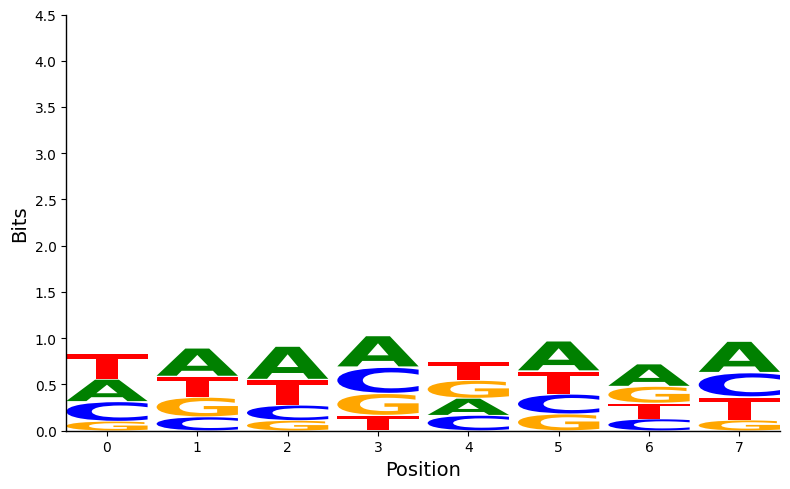

In [15]:
# Ensure project path is on sys.path so we can import local modules
import sys
from pathlib import Path
proj_root = '/Users/user/Downloads/02. PROJECTS/Stress-region-predictor'
if proj_root not in sys.path:
    sys.path.insert(0, proj_root)

# Run the sequence checker and produce a DNA logo PNG (no CSVs written)
import importlib
import plot.logo as pl
importlib.reload(pl)

check_sequences = pl.check_sequences
create_logo_from_list = pl.create_logo_from_list

merged = Path('/Users/user/Downloads/02. PROJECTS/Stress-region-predictor/train/data/merged_place_seq.csv')
out_png = merged.with_name(merged.stem + '_logo.png')

if merged.exists():
    # validate sequences in-memory (no output CSV)
    df_checked = check_sequences(str(merged), out_path=None)
    df_valid = df_checked[df_checked['Valid'] == True]
    if df_valid.empty:
        print('No valid sequences to plot.')
    else:
        sequences = df_valid['Sequence'].astype(str).tolist()
        png_path = create_logo_from_list(sequences, str(merged.parent), merged.stem + '_logo', clean_noise=True, seq_type='dna')
        print(f'Logo saved to: {png_path}')
else:
    print(f"Merged file not found: {merged}")